# CZII YOLO11 Training Baseline
 We created a training set adapted to YOLO from [the dataset baseline](https://www.kaggle.com/code/itsuki9180/czii-making-datasets-for-yolo).

In this notebook, we actually use it to train YOLO so that it can infer the xy coordinates of particles through 2D object detection.

# Install and Import modules

In [1]:
# !tar xfvz /kaggle/input/ultralytics-for-offline-install/archive.tar.gz
# !pip install --no-index --find-links=./packages ultralytics
# !rm -rf ./packages

In [2]:
EXP_NAME = "cv_mod_resize_35"
LIST_CV = [
    'TS_5_4',
    'TS_69_2',
    'TS_6_4',
    'TS_6_6',
]

PROC_RAW = "proc/yolo11_cv_mod_resize"

PROC = f"../../{PROC_RAW}"
PROC_YAML = f"/workspace/CZII/{PROC_RAW}"

In [3]:
from tqdm import tqdm
import glob, os
from ultralytics import YOLO

# Prepare to train and instance YOLOmodel

In [4]:
yaml_content = f"""
train: {PROC_YAML}/train.txt
val: {PROC_YAML}/val.txt
nc: 6

# Classes
names:
  0: apo-ferritin
  1: beta-amylase
  2: beta-galactosidase
  3: ribosome
  4: thyroglobulin
  5: virus-like-particle
"""

with open(f'{PROC}/cv_conf.yaml', 'w') as f:
    f.write(yaml_content.strip())

# Let's train YOLO!

In [5]:
def list_all_images(root_dir, extensions="png"):
    """指定ディレクトリ以下の画像ファイルパスを再帰的に取得してリストで返す。"""
    all_paths = []
    search_pattern = os.path.join(root_dir, "**", f"*.{extensions}")
    paths = glob.glob(search_pattern, recursive=True)
    all_paths.extend(paths)
    return all_paths

def contains_val_keyword(path, keyword):
    """
    ファイルパスのファイル名に `keyword` が含まれているか確認。
    Trueならval、Falseならtrainとする。
    """
    filename = os.path.basename(path)  # ディレクトリを除いたファイル名を取得
    return keyword in filename

def extract_train_val_paths(keyword):

    image_paths = list_all_images(f"{PROC_YAML}/images")
    image_paths.sort()
    # print(image_paths)

    train_paths = []
    val_paths   = []

    # ファイル名をみて振り分け
    for p in image_paths:
        if contains_val_keyword(p, keyword):
            val_paths.append(p)
        else:
            train_paths.append(p)

    print(f"Found {len(train_paths)} train images.")
    print(f"Found {len(val_paths)} val images.")

    # train.txt と val.txt に書き出し
    with open(f"{PROC}/train.txt", "w") as f:
        for path in train_paths:
            f.write(path + "\n")

    with open(f"{PROC}/val.txt", "w") as f:
        for path in val_paths:
            f.write(path + "\n")

    print(f"Train list saved to {f"{PROC}/train.txt"}")
    print(f"Val list saved to {f"{PROC}/val.txt"}")

In [6]:
for cv_name in LIST_CV:
    print("="*100)
    print(f"Processing {cv_name}...")
    extract_train_val_paths(cv_name)

    # Load a pretrained model
    model = YOLO("yolo11l.pt")  # load a pretrained model (recommended for training)

    # Train the model
    _ = model.train(
        data=f"{PROC}/cv_conf.yaml",
        name=EXP_NAME,
        epochs=35,
        warmup_epochs=3,
        optimizer='AdamW',
        cos_lr=True,
        lr0=5e-5,
        lrf=0.01,
        imgsz=640,
        device="0",
        weight_decay=0.01,
        batch=16,
        scale=0,
        flipud=0.5,
        fliplr=0.5,
        degrees=90,
        shear=5,
        mixup=0.2,
        copy_paste=0.25,
        seed=8620, # (｡•◡•｡)
    )

Processing TS_5_4...
Found 1104 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_cv_mod_resize/train.txt
Val list saved to ../../proc/yolo11_cv_mod_resize/val.txt


New https://pypi.org/project/ultralytics/8.3.70 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=../../proc/yolo11_cv_mod_resize/cv_conf.yaml, epochs=35, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=cv_mod_resize_35, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=8620, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, 

train: Scanning /workspace/CZII/proc/yolo11_cv_mod_resize/labels... 1104 images, 272 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:05<00:00, 191.67it/s]


train: New cache created: /workspace/CZII/proc/yolo11_cv_mod_resize/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: '2.0.2' (you have '2.0.0'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_cv_mod_resize/labels... 184 images, 30 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 177.43it/s]

val: New cache created: /workspace/CZII/proc/yolo11_cv_mod_resize/labels.cache


Plotting labels to /workspace/CZII/runs/detect/cv_mod_resize_35/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(21860c6b4dcf4d96be980d64ca7993ae) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/cv_mod_resize_35
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35        11G      1.955      2.316      1.433        468        640: 100%|██████████| 69/69 [00:31<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.13s/it]

                   all        184       2640      0.328      0.385      0.282     0.0957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/35        11G      1.399      1.433      1.119        498        640: 100%|██████████| 69/69 [00:29<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        184       2640      0.489      0.518      0.477      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/35        11G      1.274      1.298      1.073        302        640: 100%|██████████| 69/69 [00:28<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       2640       0.54      0.572      0.545      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/35        11G      1.276      1.282       1.07        503        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       2640      0.543      0.573      0.576       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/35        11G      1.225      1.217      1.049        526        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       2640      0.542      0.585      0.573      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/35        11G      1.203      1.198      1.042        498        640: 100%|██████████| 69/69 [00:28<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        184       2640      0.568       0.58      0.569      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/35        11G      1.172      1.174      1.031        266        640: 100%|██████████| 69/69 [00:28<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.64it/s]

                   all        184       2640      0.591      0.581      0.591      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/35        11G      1.163      1.156      1.026        318        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.61it/s]

                   all        184       2640      0.576      0.584      0.593      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/35      10.9G      1.152      1.152      1.021        327        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       2640      0.557      0.586      0.572      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/35      11.1G      1.116      1.118       1.01        388        640: 100%|██████████| 69/69 [00:28<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.62it/s]

                   all        184       2640      0.563      0.606      0.598      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/35      11.1G      1.095      1.122      1.008        414        640: 100%|██████████| 69/69 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.71it/s]

                   all        184       2640       0.57      0.588      0.595      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/35        11G      1.099      1.117      1.003        417        640: 100%|██████████| 69/69 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       2640      0.554      0.583       0.59      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/35        11G      1.091      1.084          1        627        640: 100%|██████████| 69/69 [00:28<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.69it/s]

                   all        184       2640      0.558      0.585      0.594      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/35        11G      1.076      1.072     0.9986        463        640: 100%|██████████| 69/69 [00:28<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.65it/s]

                   all        184       2640      0.592      0.581      0.593      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/35      11.1G       1.08      1.083     0.9992        333        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.62it/s]

                   all        184       2640      0.569      0.587      0.598      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/35        11G      1.052      1.056      0.989        354        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2640      0.587      0.607      0.607      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/35      10.9G      1.063       1.07     0.9909        532        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       2640      0.583      0.587      0.596      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/35      11.1G      1.082      1.056     0.9977        352        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       2640      0.572      0.611      0.619      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/35        11G       1.06       1.07     0.9932        400        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2640      0.635        0.6      0.611      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/35        11G      1.027      1.046     0.9807        371        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       2640      0.584      0.587       0.61      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/35      11.1G      1.054       1.04     0.9864        411        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        184       2640      0.546      0.603      0.591      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/35      10.9G      1.025      1.009     0.9777        502        640: 100%|██████████| 69/69 [00:29<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       2640      0.549      0.604      0.598      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/35        11G      1.034       1.03     0.9798        479        640: 100%|██████████| 69/69 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2640      0.551      0.606      0.606      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/35        11G      1.036      1.023     0.9842        376        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.66it/s]

                   all        184       2640      0.588      0.592      0.603      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/35        11G     0.9996       1.01     0.9702        385        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       2640      0.603      0.586      0.608      0.427


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/35        11G     0.9192     0.9446     0.9371        270        640: 100%|██████████| 69/69 [00:28<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2640      0.591      0.577      0.602      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/35        11G     0.9183     0.9381     0.9347        346        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       2640      0.605      0.595      0.608      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/35        11G     0.9103     0.9144      0.932        272        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2640      0.582      0.597      0.609      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/35      10.9G     0.9049     0.9124     0.9315        356        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2640      0.567      0.582      0.599      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/35      10.9G      0.899      0.901     0.9302        255        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

                   all        184       2640      0.582      0.585      0.604      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/35      10.9G     0.8992     0.9022      0.928        250        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       2640      0.586      0.592      0.604      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/35      10.9G     0.8831     0.8845     0.9267        283        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]

                   all        184       2640       0.58      0.587      0.603      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/35      10.9G     0.8846     0.8906     0.9256        289        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2640      0.592      0.594      0.606       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/35      10.9G     0.8907      0.895     0.9279        220        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2640      0.586      0.581      0.604      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/35      10.9G     0.8782     0.8858     0.9276        202        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2640      0.581      0.595      0.604       0.44



35 epochs completed in 0.321 hours.
Optimizer stripped from /workspace/CZII/runs/detect/cv_mod_resize_35/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/cv_mod_resize_35/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/cv_mod_resize_35/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


                   all        184       2640      0.582      0.597      0.609      0.443
          apo-ferritin        133        506      0.657      0.757      0.771      0.509
    beta-galactosidase        112        200       0.38       0.21      0.243      0.158
              ribosome        145        899      0.687       0.76      0.793      0.574
         thyroglobulin        144        749       0.33      0.319      0.266      0.169
   virus-like-particle        105        286      0.854      0.941       0.97      0.807
Speed: 0.3ms preprocess, 19.8ms inference, 0.0ms loss, 13.1ms postprocess per image
Results saved to /workspace/CZII/runs/detect/cv_mod_resize_35
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Processing TS_69_2...
Found 1104 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_cv_mod_resize/train.txt
Val list saved to ../../proc/yolo11_cv_mod_resize/val.txt
New https://pypi.org/projec

train: Scanning /workspace/CZII/proc/yolo11_cv_mod_resize/labels... 1104 images, 220 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:05<00:00, 199.96it/s]

train: New cache created: /workspace/CZII/proc/yolo11_cv_mod_resize/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_cv_mod_resize/labels... 184 images, 82 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 181.73it/s]

val: New cache created: /workspace/CZII/proc/yolo11_cv_mod_resize/labels.cache


Plotting labels to /workspace/CZII/runs/detect/cv_mod_resize_352/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(8f1b796211d74759a4d6c18982fba20b) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/cv_mod_resize_352
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35      11.6G      1.981      2.359      1.449        479        640: 100%|██████████| 69/69 [00:30<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.31it/s]

                   all        184       2814      0.404      0.346      0.361      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/35      11.5G      1.411      1.473      1.125        496        640: 100%|██████████| 69/69 [00:28<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]

                   all        184       2814      0.395      0.425      0.398     0.0587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/35      11.5G        1.3       1.33      1.082        273        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

                   all        184       2814      0.467       0.54       0.53      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/35      11.6G      1.288      1.296      1.071        512        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.98it/s]

                   all        184       2814      0.518        0.5      0.549       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/35      11.6G      1.237      1.233      1.052        527        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]

                   all        184       2814      0.503      0.591      0.565      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/35      11.6G      1.223      1.217       1.05        457        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

                   all        184       2814      0.528      0.588      0.569      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/35      11.6G        1.2      1.192      1.043        254        640: 100%|██████████| 69/69 [00:27<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        184       2814      0.529       0.58      0.565      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/35      11.6G      1.176      1.169       1.03        315        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]

                   all        184       2814      0.548      0.538      0.574       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/35      11.6G      1.159      1.159      1.022        333        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

                   all        184       2814      0.552      0.555      0.573      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/35      11.7G      1.129      1.131      1.014        374        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]

                   all        184       2814      0.602      0.574      0.583      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/35      11.6G      1.105      1.128       1.01        424        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]

                   all        184       2814      0.534      0.569      0.583      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/35      11.6G      1.122      1.139       1.01        411        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]

                   all        184       2814       0.57      0.611      0.592      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/35      11.6G       1.12      1.109      1.009        599        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.98it/s]

                   all        184       2814      0.562      0.572      0.582      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/35      11.6G      1.098      1.099      1.004        456        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.75it/s]

                   all        184       2814      0.543      0.585      0.586      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/35      11.7G      1.083      1.092     0.9985        361        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]

                   all        184       2814      0.593      0.584      0.586      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/35      11.6G      1.071      1.078     0.9949        363        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

                   all        184       2814      0.579      0.609      0.595      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/35      11.5G      1.067      1.075     0.9918        497        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

                   all        184       2814      0.548      0.577      0.589      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/35      11.7G      1.089       1.07     0.9986        336        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       2814      0.581      0.617      0.597      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/35      11.7G      1.061      1.057     0.9914        413        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.00it/s]

                   all        184       2814      0.591      0.594      0.593       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/35      11.6G      1.047      1.066     0.9871        354        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.00it/s]

                   all        184       2814      0.583      0.605      0.598      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/35      11.6G      1.063      1.054     0.9893        405        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.00it/s]

                   all        184       2814      0.582      0.588      0.592       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/35      11.5G      1.039      1.024     0.9806        503        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

                   all        184       2814        0.6       0.61       0.59      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/35      11.6G      1.049      1.048     0.9836        495        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

                   all        184       2814       0.56       0.61      0.588      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/35      11.5G       1.04      1.033     0.9842        394        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2814      0.575      0.615      0.593      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/35      11.6G       1.01      1.022     0.9732        356        640: 100%|██████████| 69/69 [00:28<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        184       2814      0.589      0.598      0.595      0.444


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/35      11.5G     0.9349     0.9623     0.9416        270        640: 100%|██████████| 69/69 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.96it/s]

                   all        184       2814      0.582      0.597      0.595      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/35      11.6G     0.9321     0.9369     0.9382        359        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]

                   all        184       2814      0.591      0.605      0.597      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/35      11.5G     0.9229     0.9179     0.9338        254        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]

                   all        184       2814      0.572      0.628      0.597       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/35      11.5G     0.9169     0.9242     0.9349        312        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

                   all        184       2814      0.572      0.615      0.591      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/35      11.5G     0.9155     0.9045     0.9342        262        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.98it/s]

                   all        184       2814      0.577       0.62      0.595      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/35      11.5G     0.9095     0.9079      0.931        237        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]

                   all        184       2814      0.588      0.625      0.596      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/35      11.5G     0.8988     0.8917     0.9305        287        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]

                   all        184       2814      0.577      0.626      0.594      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/35      11.4G     0.8987      0.891      0.929        319        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]

                   all        184       2814      0.582      0.636      0.595      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/35      11.5G     0.9041     0.8946     0.9303        205        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]

                   all        184       2814      0.575      0.629      0.594      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/35      11.5G     0.8949     0.8917     0.9305        229        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       2814      0.574      0.623      0.594      0.448



35 epochs completed in 0.317 hours.
Optimizer stripped from /workspace/CZII/runs/detect/cv_mod_resize_352/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/cv_mod_resize_352/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/cv_mod_resize_352/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


                   all        184       2814       0.57      0.628      0.597      0.449
          apo-ferritin         75        385      0.592       0.73      0.646       0.44
    beta-galactosidase         86        272      0.336      0.232      0.213      0.123
              ribosome         96       1073      0.848      0.809      0.897      0.675
         thyroglobulin        100        850      0.322      0.398      0.259      0.161
   virus-like-particle         56        234      0.753       0.97      0.971      0.847
Speed: 0.3ms preprocess, 6.5ms inference, 0.1ms loss, 19.4ms postprocess per image
Results saved to /workspace/CZII/runs/detect/cv_mod_resize_352
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Processing TS_6_4...
Found 1104 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_cv_mod_resize/train.txt
Val list saved to ../../proc/yolo11_cv_mod_resize/val.txt
New https://pypi.org/project

train: Scanning /workspace/CZII/proc/yolo11_cv_mod_resize/labels... 1104 images, 263 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:05<00:00, 200.68it/s]

train: New cache created: /workspace/CZII/proc/yolo11_cv_mod_resize/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_cv_mod_resize/labels... 184 images, 39 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 176.14it/s]

val: New cache created: /workspace/CZII/proc/yolo11_cv_mod_resize/labels.cache


Plotting labels to /workspace/CZII/runs/detect/cv_mod_resize_353/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(702ce422d5b24bb18de89db074d88f27) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/cv_mod_resize_353
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35      11.6G      1.954       2.37      1.417        461        640: 100%|██████████| 69/69 [00:30<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.61it/s]

                   all        184       3998      0.331       0.38      0.277     0.0897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/35      11.7G      1.384      1.457      1.111        472        640: 100%|██████████| 69/69 [00:29<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.58it/s]

                   all        184       3998      0.489      0.509      0.458      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/35      11.5G      1.276      1.329      1.071        257        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       3998      0.496      0.555      0.507      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/35      11.6G      1.258      1.296      1.059        444        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]

                   all        184       3998      0.587      0.529      0.505      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/35      11.5G       1.22      1.234      1.045        512        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       3998      0.532      0.601      0.543      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/35      11.6G      1.189      1.224      1.037        439        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       3998      0.525      0.561      0.536      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/35      11.6G      1.153      1.195      1.026        206        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       3998      0.513      0.589      0.532      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/35      11.6G       1.15      1.177      1.021        313        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

                   all        184       3998      0.505      0.563       0.53      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/35      11.6G      1.145      1.158      1.016        308        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       3998      0.527      0.549      0.538      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/35      11.7G      1.118      1.138      1.009        376        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.73it/s]

                   all        184       3998      0.517      0.591      0.545      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/35      11.6G      1.094      1.129      1.004        429        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]

                   all        184       3998      0.516      0.579      0.544      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/35      11.6G      1.093      1.139      0.999        386        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       3998      0.543      0.605      0.561      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/35      11.6G      1.105      1.111      1.004        584        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       3998      0.629      0.572      0.557      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/35      11.6G      1.067      1.095     0.9942        435        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.66it/s]

                   all        184       3998      0.572      0.581      0.564      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/35      11.7G      1.069      1.096     0.9927        334        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       3998      0.534      0.571       0.55      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/35      11.6G      1.048      1.075     0.9844        384        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       3998      0.557      0.595      0.563      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/35      11.5G      1.049      1.076     0.9835        472        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       3998      0.503      0.579      0.546      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/35      11.7G      1.075      1.073     0.9918        315        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       3998      0.527      0.586      0.562      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/35      11.7G      1.039      1.058     0.9831        415        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       3998      0.534      0.606      0.564      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/35      11.6G      1.032      1.067      0.981        355        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       3998      0.536      0.605      0.566       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/35      11.6G      1.058       1.06      0.985        327        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       3998      0.548       0.59      0.569      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/35      11.5G      1.028      1.024     0.9768        495        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       3998      0.534      0.596      0.571      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/35      11.6G      1.027      1.046     0.9762        485        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       3998      0.544      0.596      0.572      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/35      11.6G      1.025      1.035     0.9773        355        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       3998      0.531      0.607      0.572      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/35      11.6G     0.9944      1.018      0.967        346        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.66it/s]

                   all        184       3998      0.545      0.588      0.565      0.389


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/35      11.6G     0.9134     0.9584     0.9341        265        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.64it/s]

                   all        184       3998      0.557       0.59      0.575      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/35      11.5G      0.914     0.9375     0.9307        323        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.62it/s]

                   all        184       3998      0.543      0.602      0.576      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/35      11.5G     0.9015     0.9212     0.9268        251        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       3998      0.538      0.595      0.568      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/35      11.5G     0.8996     0.9199     0.9286        295        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]

                   all        184       3998      0.537      0.593      0.563      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/35      11.5G     0.8985     0.9058     0.9277        262        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]

                   all        184       3998      0.538      0.596      0.569      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/35      11.5G     0.8905     0.9084     0.9239        214        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]

                   all        184       3998      0.532       0.61      0.568        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/35      11.5G     0.8744     0.8923     0.9232        281        640: 100%|██████████| 69/69 [00:29<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.59it/s]

                   all        184       3998      0.529      0.606      0.565      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/35      11.5G     0.8824     0.8981      0.924        289        640: 100%|██████████| 69/69 [00:29<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.59it/s]

                   all        184       3998      0.529      0.604      0.568      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/35      11.5G      0.886     0.8926     0.9244        176        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.60it/s]

                   all        184       3998      0.532      0.587      0.565      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/35      11.5G     0.8768        0.9     0.9251        208        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       3998      0.529      0.587      0.566      0.398



35 epochs completed in 0.319 hours.
Optimizer stripped from /workspace/CZII/runs/detect/cv_mod_resize_353/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/cv_mod_resize_353/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/cv_mod_resize_353/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


                   all        184       3998      0.543      0.602      0.576      0.403
          apo-ferritin        121        638      0.635      0.787       0.77      0.538
    beta-galactosidase         89        204       0.45       0.16      0.254      0.123
              ribosome        129       2146      0.648      0.875      0.781      0.546
         thyroglobulin        125        750      0.325       0.44      0.317      0.193
   virus-like-particle         75        260      0.658      0.746      0.756      0.616
Speed: 0.2ms preprocess, 6.5ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /workspace/CZII/runs/detect/cv_mod_resize_353
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Processing TS_6_6...
Found 1104 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_cv_mod_resize/train.txt
Val list saved to ../../proc/yolo11_cv_mod_resize/val.txt
New https://pypi.org/project/

train: Scanning /workspace/CZII/proc/yolo11_cv_mod_resize/labels... 1104 images, 278 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:05<00:00, 198.62it/s]

train: New cache created: /workspace/CZII/proc/yolo11_cv_mod_resize/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_cv_mod_resize/labels... 184 images, 24 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 171.67it/s]


val: New cache created: /workspace/CZII/proc/yolo11_cv_mod_resize/labels.cache
Plotting labels to /workspace/CZII/runs/detect/cv_mod_resize_354/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(3d29acf33113444e91fb55b714778647) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/cv_mod_resize_354
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35      11.6G      1.944      2.332      1.424        530        640: 100%|██████████| 69/69 [00:31<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.60it/s]

                   all        184       2674      0.299        0.3      0.234      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/35      11.8G      1.361      1.423      1.108        491        640: 100%|██████████| 69/69 [00:29<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        184       2674      0.465      0.506      0.502      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/35      11.6G      1.278       1.33      1.075        260        640: 100%|██████████| 69/69 [00:28<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       2674      0.462      0.538      0.505     0.0826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/35      11.6G       1.26      1.298      1.063        457        640: 100%|██████████| 69/69 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       2674      0.406       0.57      0.563      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/35      11.6G      1.226      1.223      1.051        537        640: 100%|██████████| 69/69 [00:29<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       2674      0.518      0.592      0.568      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/35      11.6G      1.193       1.22      1.042        476        640: 100%|██████████| 69/69 [00:28<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.70it/s]

                   all        184       2674      0.529      0.587      0.574      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/35      11.6G      1.162      1.194      1.029        222        640: 100%|██████████| 69/69 [00:31<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.87it/s]

                   all        184       2674      0.536      0.604      0.578      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/35      11.6G      1.156      1.171      1.022        315        640: 100%|██████████| 69/69 [00:28<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.70it/s]

                   all        184       2674      0.572       0.58      0.588      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/35      11.6G       1.15      1.162      1.022        384        640: 100%|██████████| 69/69 [00:30<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2674      0.565      0.608      0.595      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/35      11.7G      1.125      1.129      1.015        386        640: 100%|██████████| 69/69 [00:29<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       2674      0.586      0.607      0.599       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/35      11.6G      1.102      1.126      1.008        468        640: 100%|██████████| 69/69 [00:29<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]

                   all        184       2674      0.592      0.634      0.609       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/35      11.6G      1.105      1.147      1.006        425        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all        184       2674      0.551      0.617      0.591      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/35      11.6G      1.117      1.109      1.008        612        640: 100%|██████████| 69/69 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       2674      0.559      0.612      0.598      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/35      11.6G      1.076      1.096     0.9977        480        640: 100%|██████████| 69/69 [00:29<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]

                   all        184       2674      0.599      0.601      0.604      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/35      11.7G      1.076      1.086     0.9958        332        640: 100%|██████████| 69/69 [00:29<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       2674      0.565        0.6        0.6      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/35      11.7G       1.05       1.08     0.9874        380        640: 100%|██████████| 69/69 [00:28<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2674      0.574      0.626      0.605      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/35      11.5G      1.057       1.07     0.9886        487        640: 100%|██████████| 69/69 [00:28<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        184       2674      0.584      0.627      0.602      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/35      11.7G      1.072      1.064     0.9938        338        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        184       2674      0.581      0.616      0.611      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/35      11.7G      1.039       1.05     0.9854        434        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        184       2674      0.579      0.623      0.611      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/35      11.6G      1.037      1.061     0.9851        365        640: 100%|██████████| 69/69 [00:28<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       2674      0.606      0.609      0.623      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/35      11.7G      1.058       1.06     0.9864        345        640: 100%|██████████| 69/69 [00:29<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.66it/s]

                   all        184       2674      0.581      0.617      0.622      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/35      11.5G      1.027      1.017     0.9781        521        640: 100%|██████████| 69/69 [00:30<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.06it/s]

                   all        184       2674      0.595      0.627      0.623      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/35      11.6G       1.03      1.042       0.98        562        640: 100%|██████████| 69/69 [00:28<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       2674      0.595      0.618      0.617      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/35      11.6G      1.026      1.034     0.9813        350        640: 100%|██████████| 69/69 [00:29<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       2674      0.606      0.623      0.622      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/35      11.7G     0.9913      1.003      0.968        348        640: 100%|██████████| 69/69 [00:30<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       2674       0.59       0.62      0.615      0.439


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/35      11.5G      0.918     0.9534     0.9372        257        640: 100%|██████████| 69/69 [00:29<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

                   all        184       2674      0.601      0.606      0.622      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/35      11.6G     0.9231     0.9439     0.9351        324        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       2674       0.62      0.618      0.629      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/35      11.6G     0.9065     0.9221     0.9297        251        640: 100%|██████████| 69/69 [00:29<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       2674      0.613      0.616      0.621      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/35      11.5G     0.9015     0.9156     0.9319        312        640: 100%|██████████| 69/69 [00:29<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.67it/s]

                   all        184       2674      0.611       0.61      0.624       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/35      11.5G     0.9036     0.9034     0.9322        280        640: 100%|██████████| 69/69 [00:28<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.09it/s]

                   all        184       2674      0.633      0.598      0.627      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/35      11.5G     0.8942     0.9074     0.9282        230        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       2674      0.619      0.604      0.626      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/35      11.5G     0.8832     0.8982     0.9274        281        640: 100%|██████████| 69/69 [00:28<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       2674      0.614      0.609      0.624      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/35      11.5G     0.8844     0.9021      0.927        274        640: 100%|██████████| 69/69 [00:28<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       2674      0.606      0.616      0.625      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/35      11.5G     0.8902     0.8986     0.9282        172        640: 100%|██████████| 69/69 [00:28<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.38it/s]

                   all        184       2674      0.599      0.616      0.625      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/35      11.5G     0.8795     0.9001      0.928        239        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       2674      0.602      0.615      0.625      0.454



35 epochs completed in 0.353 hours.
Optimizer stripped from /workspace/CZII/runs/detect/cv_mod_resize_354/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/cv_mod_resize_354/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/cv_mod_resize_354/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


                   all        184       2674      0.613      0.608      0.625      0.459
          apo-ferritin        149        451      0.663      0.696      0.715      0.552
    beta-galactosidase         84        187      0.387      0.225      0.247      0.163
              ribosome        106        667       0.88      0.831      0.903       0.58
         thyroglobulin        144        875      0.348      0.366      0.312      0.204
   virus-like-particle        127        494      0.789      0.925      0.945      0.798
Speed: 0.3ms preprocess, 36.7ms inference, 0.0ms loss, 21.1ms postprocess per image
Results saved to /workspace/CZII/runs/detect/cv_mod_resize_354
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


In [7]:
# model = YOLO(f"../../runs/detect/{EXP_NAME}/weights/best.pt")
# metrics = model.val(data=f"{PROC}/czii_conf.yaml", imgsz=640, batch=16, conf=0.25, iou=0.6, device="0", save_json=True)  # no arguments needed, dataset and settings remembered
# print(metrics.box.map)  # map50-95
# print(metrics.box.map50)  # map50
# print(metrics.box.map75)  # map75
# print(metrics.box.maps)

# Prediction example

In [8]:
import pandas as pd
from IPython.display import display, HTML
from IPython.display import Image as IPyImage
pd.options.display.precision = 3

columns = [
    "metrics/precision(B)",
    "metrics/recall(B)",
    "metrics/mAP50(B)",
    "metrics/mAP50-95(B)",
]
df_result = pd.DataFrame(columns=columns)
for i in range(len(LIST_CV)):
    if i == 0:
        df = pd.read_csv(f"../../runs/detect/{EXP_NAME}/results.csv")
    else:
        df = pd.read_csv(f"../../runs/detect/{EXP_NAME}{i+1}/results.csv")
    
    list_results = [
        df.iloc[-1]["metrics/precision(B)"],
        df.iloc[-1]["metrics/recall(B)"],
        df.iloc[-1]["metrics/mAP50(B)"],
        df.iloc[-1]["metrics/mAP50-95(B)"],
    ]
    df_result.loc[f"val_{LIST_CV[i]}"] = list_results
df_result.loc["mean"] = df_result.mean()
df_result

,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B)
val_TS_5_4,0.581,0.595,0.604,0.440
val_TS_69_2,0.574,0.623,0.594,0.448
val_TS_6_4,0.529,0.587,0.566,0.398
val_TS_6_6,0.602,0.615,0.625,0.454
mean,0.572,0.605,0.597,0.435


In [9]:
# 画像を2x2のグリッドで表示
html_content = '''
<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px;">
    <img src="../../runs/detect/{}/PR_curve.png" style="width: 80%;">
    <img src="../../runs/detect/{}/PR_curve.png" style="width: 80%;">
    <img src="../../runs/detect/{}/PR_curve.png" style="width: 80%;">
    <img src="../../runs/detect/{}/PR_curve.png" style="width: 80%;">
</div>
'''.format(
    EXP_NAME,
    f"{EXP_NAME}2",
    f"{EXP_NAME}3",
    f"{EXP_NAME}4"
)

display(HTML(html_content))

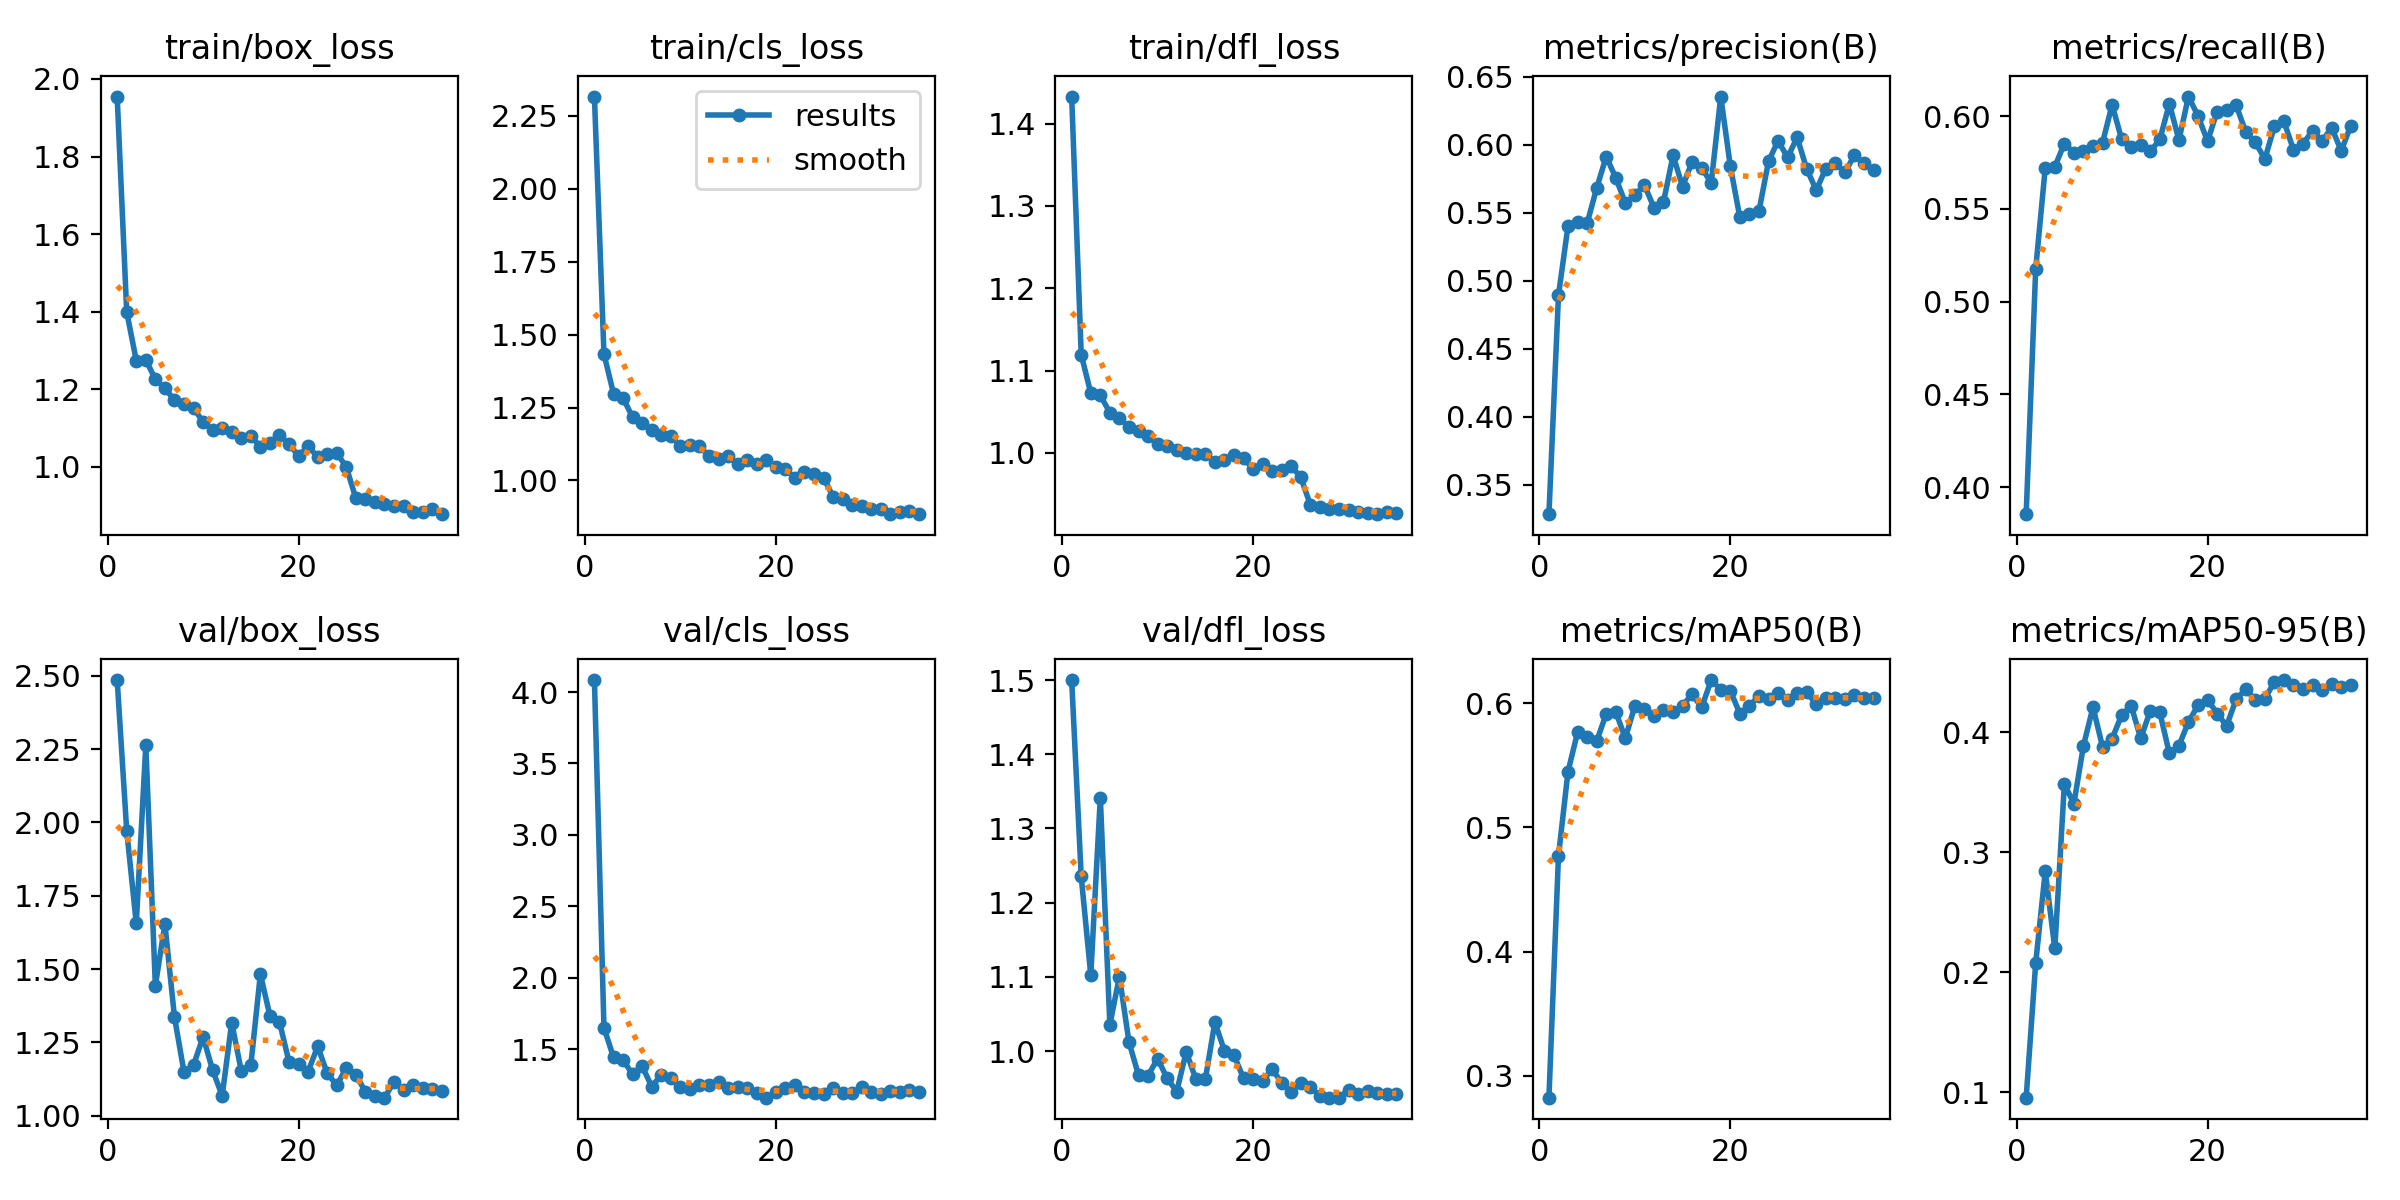

In [10]:
IPyImage(filename=f'../../runs/detect/{EXP_NAME}/results.png', width=800)

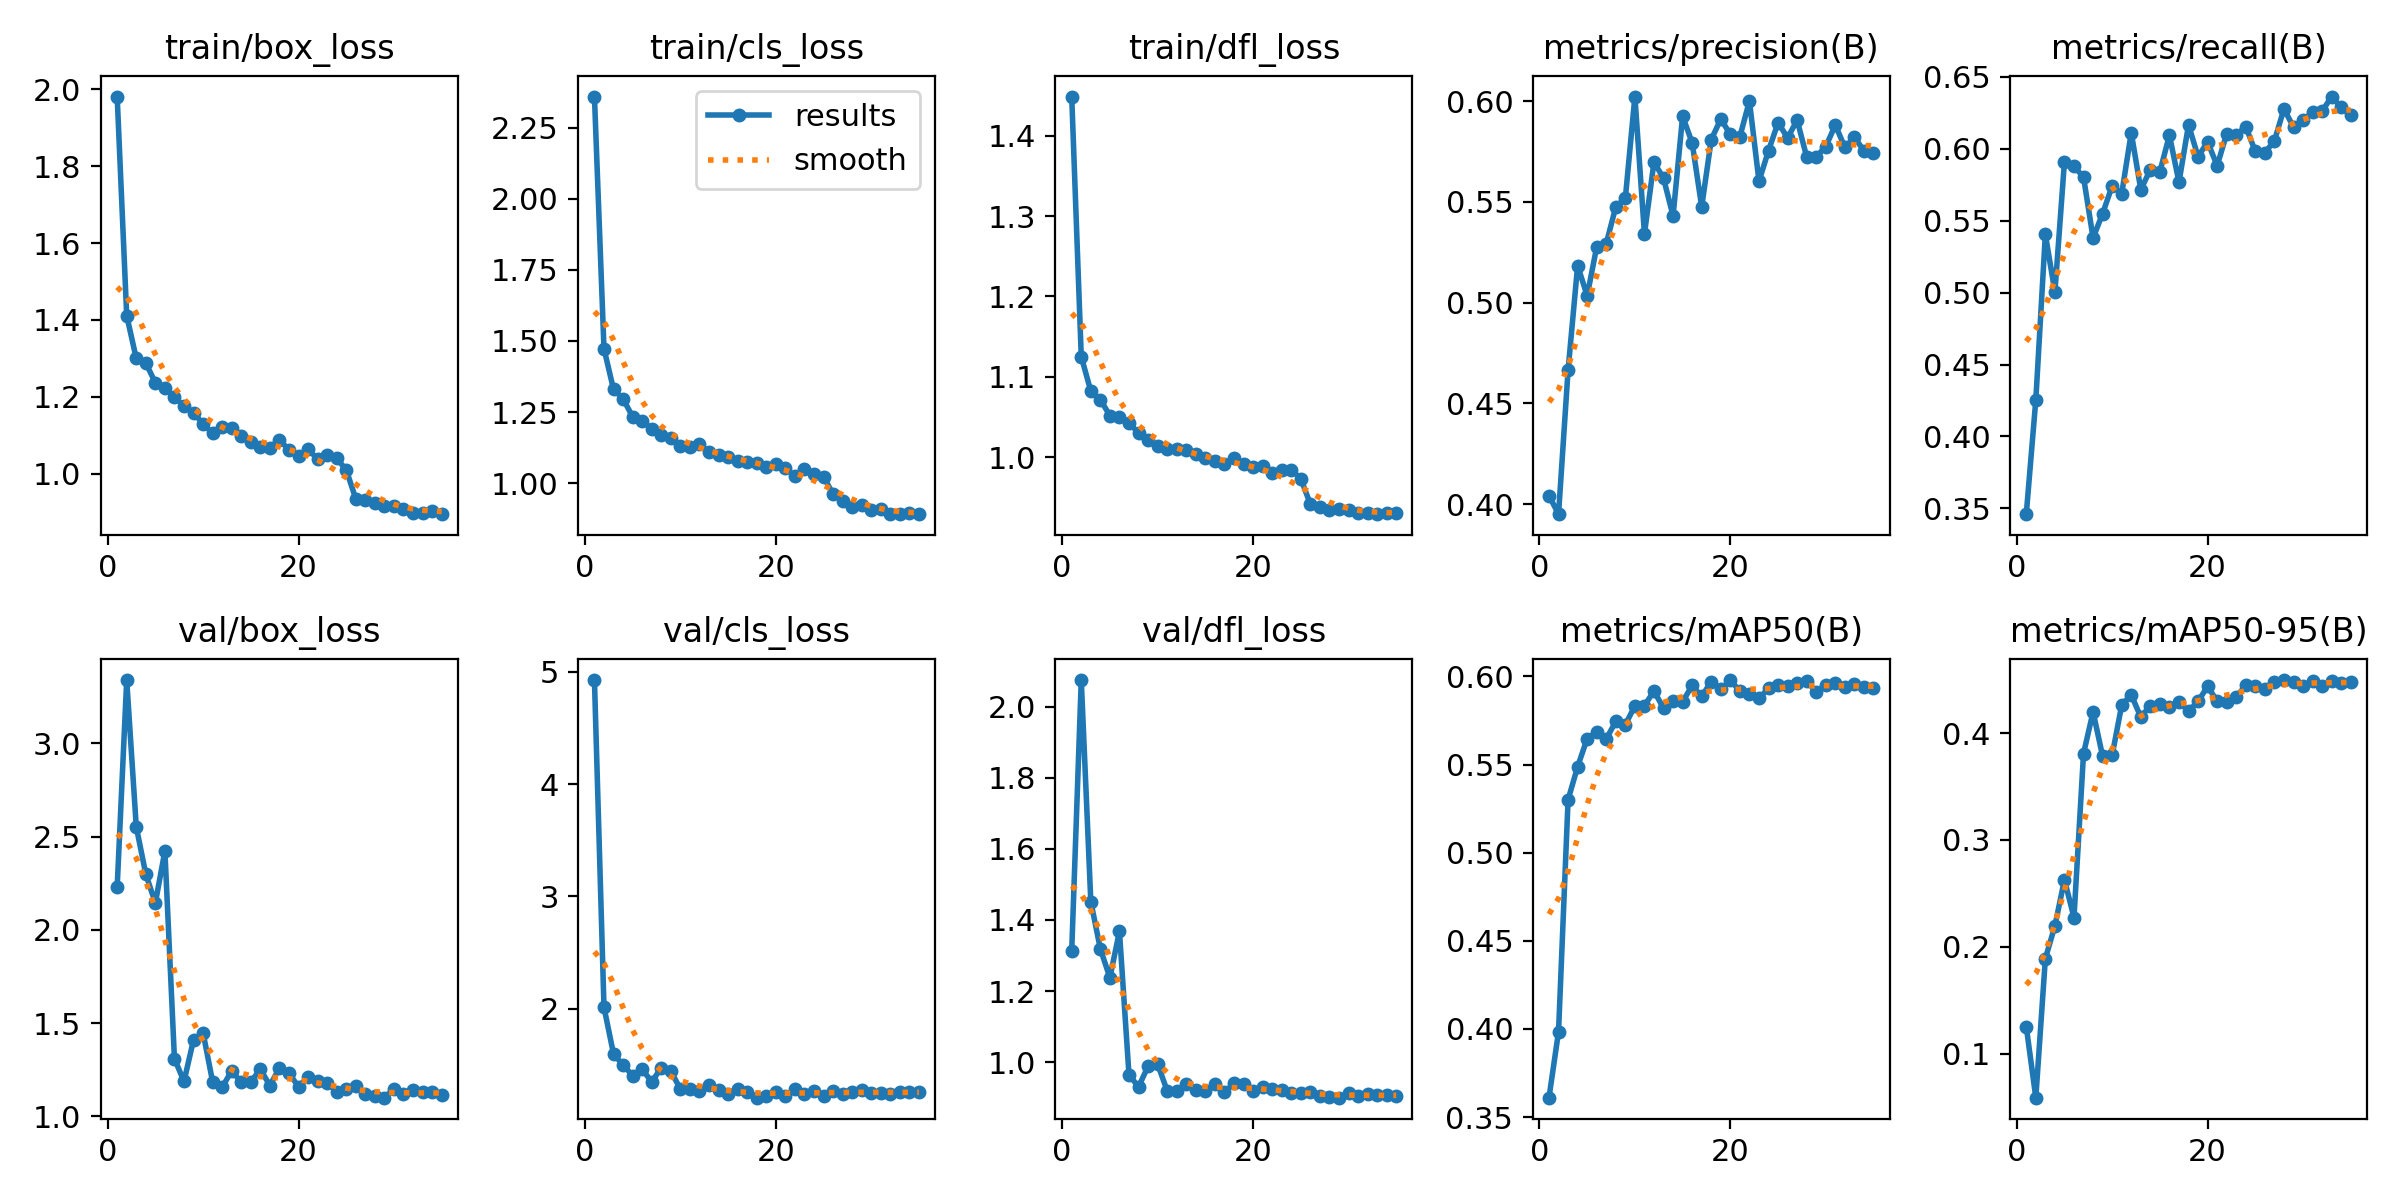

In [11]:
IPyImage(filename=f'../../runs/detect/{EXP_NAME}2/results.png', width=800)

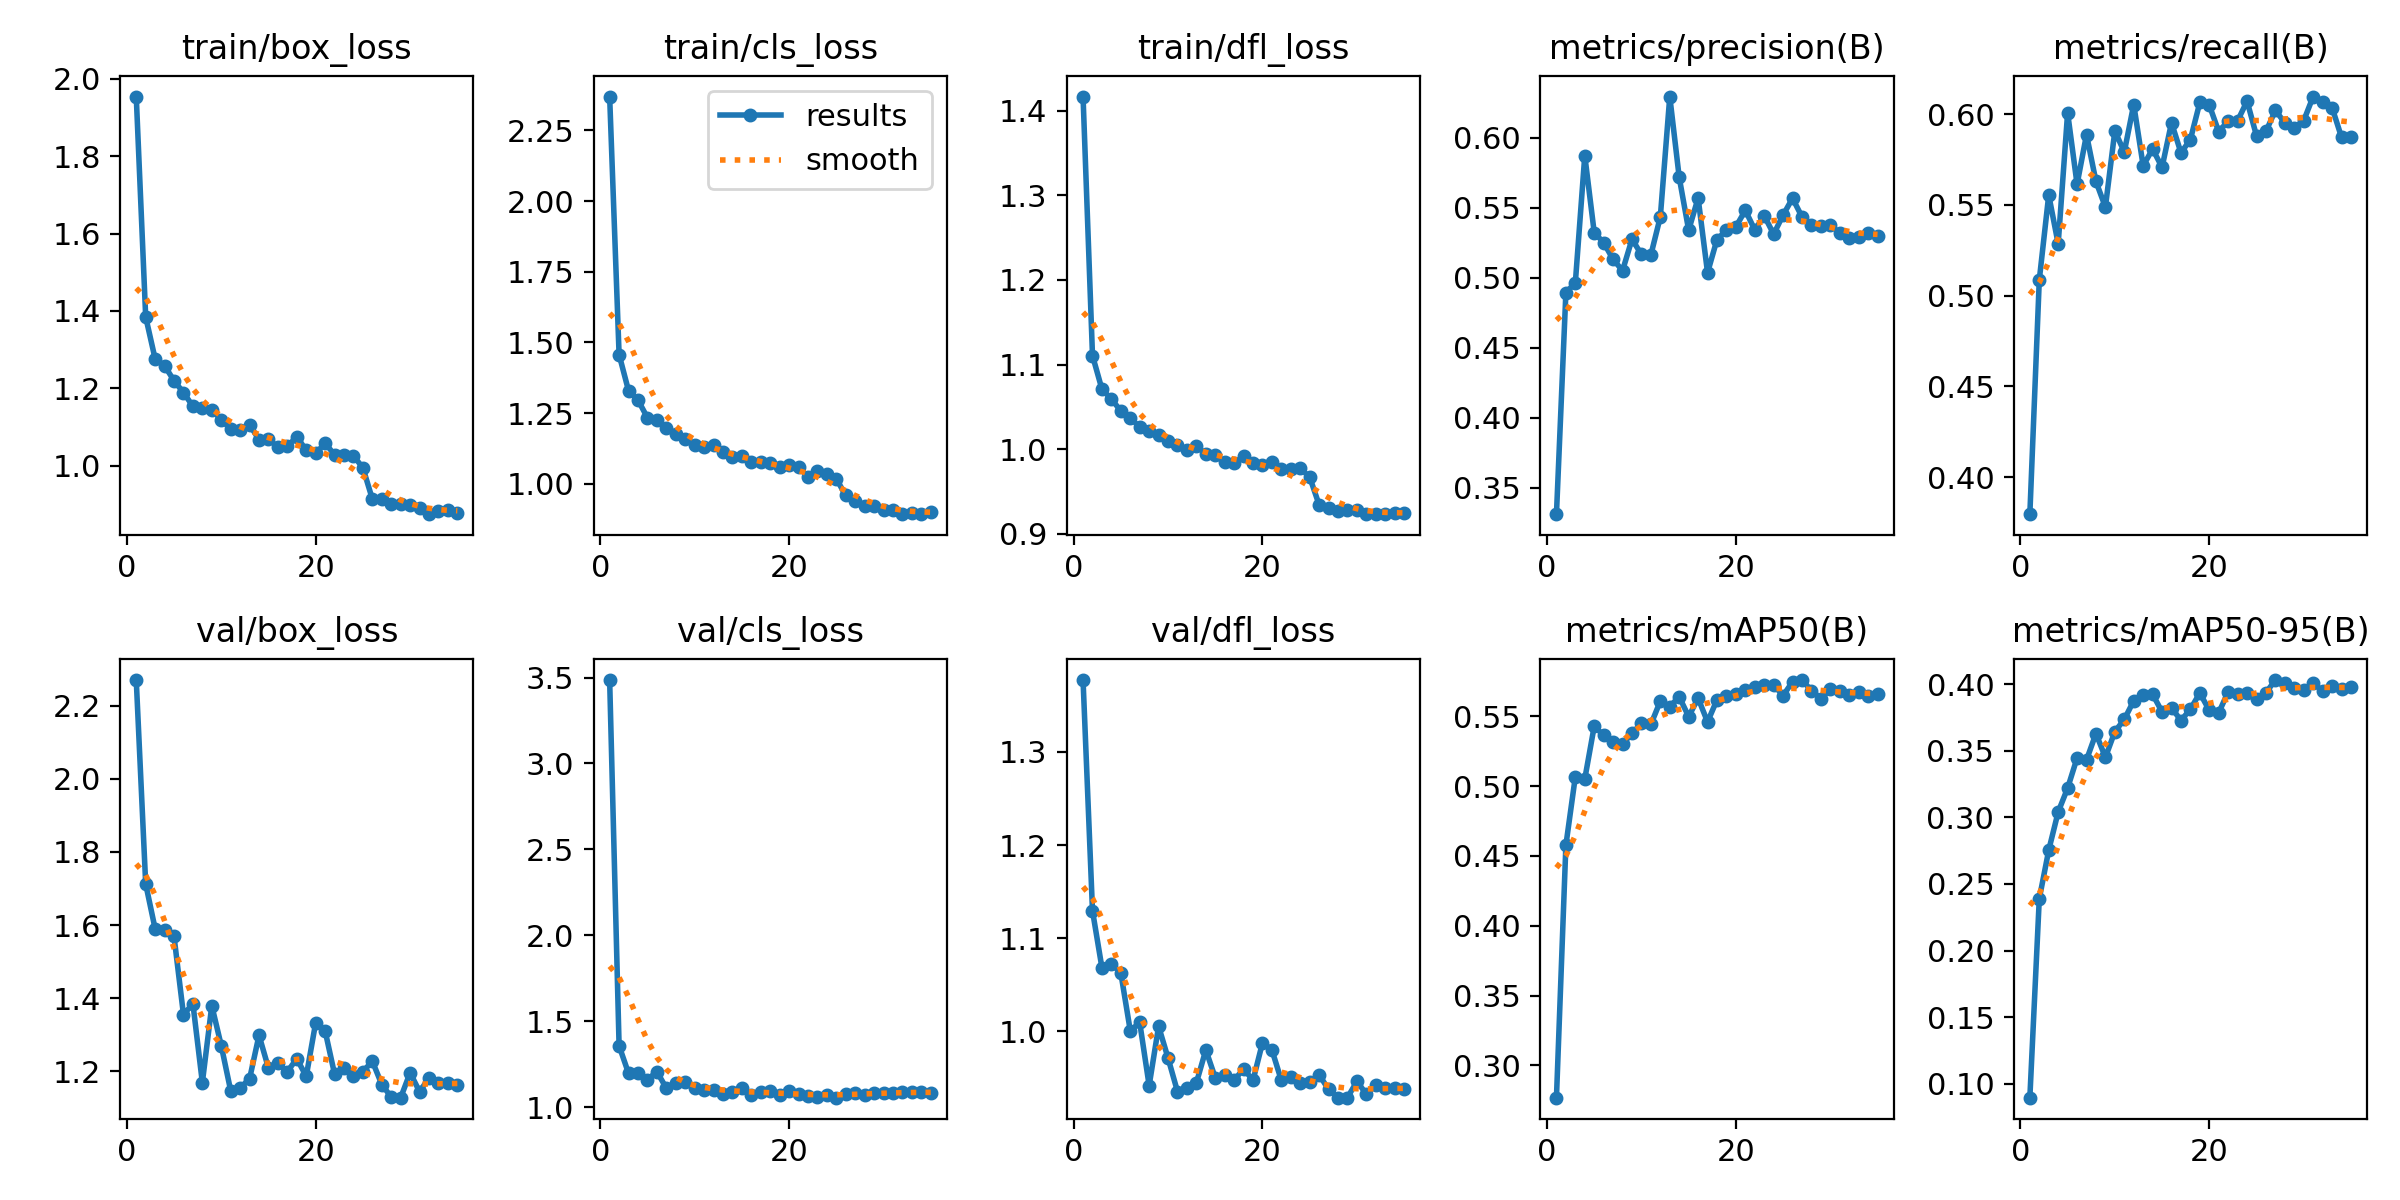

In [12]:
IPyImage(filename=f'../../runs/detect/{EXP_NAME}3/results.png', width=800)

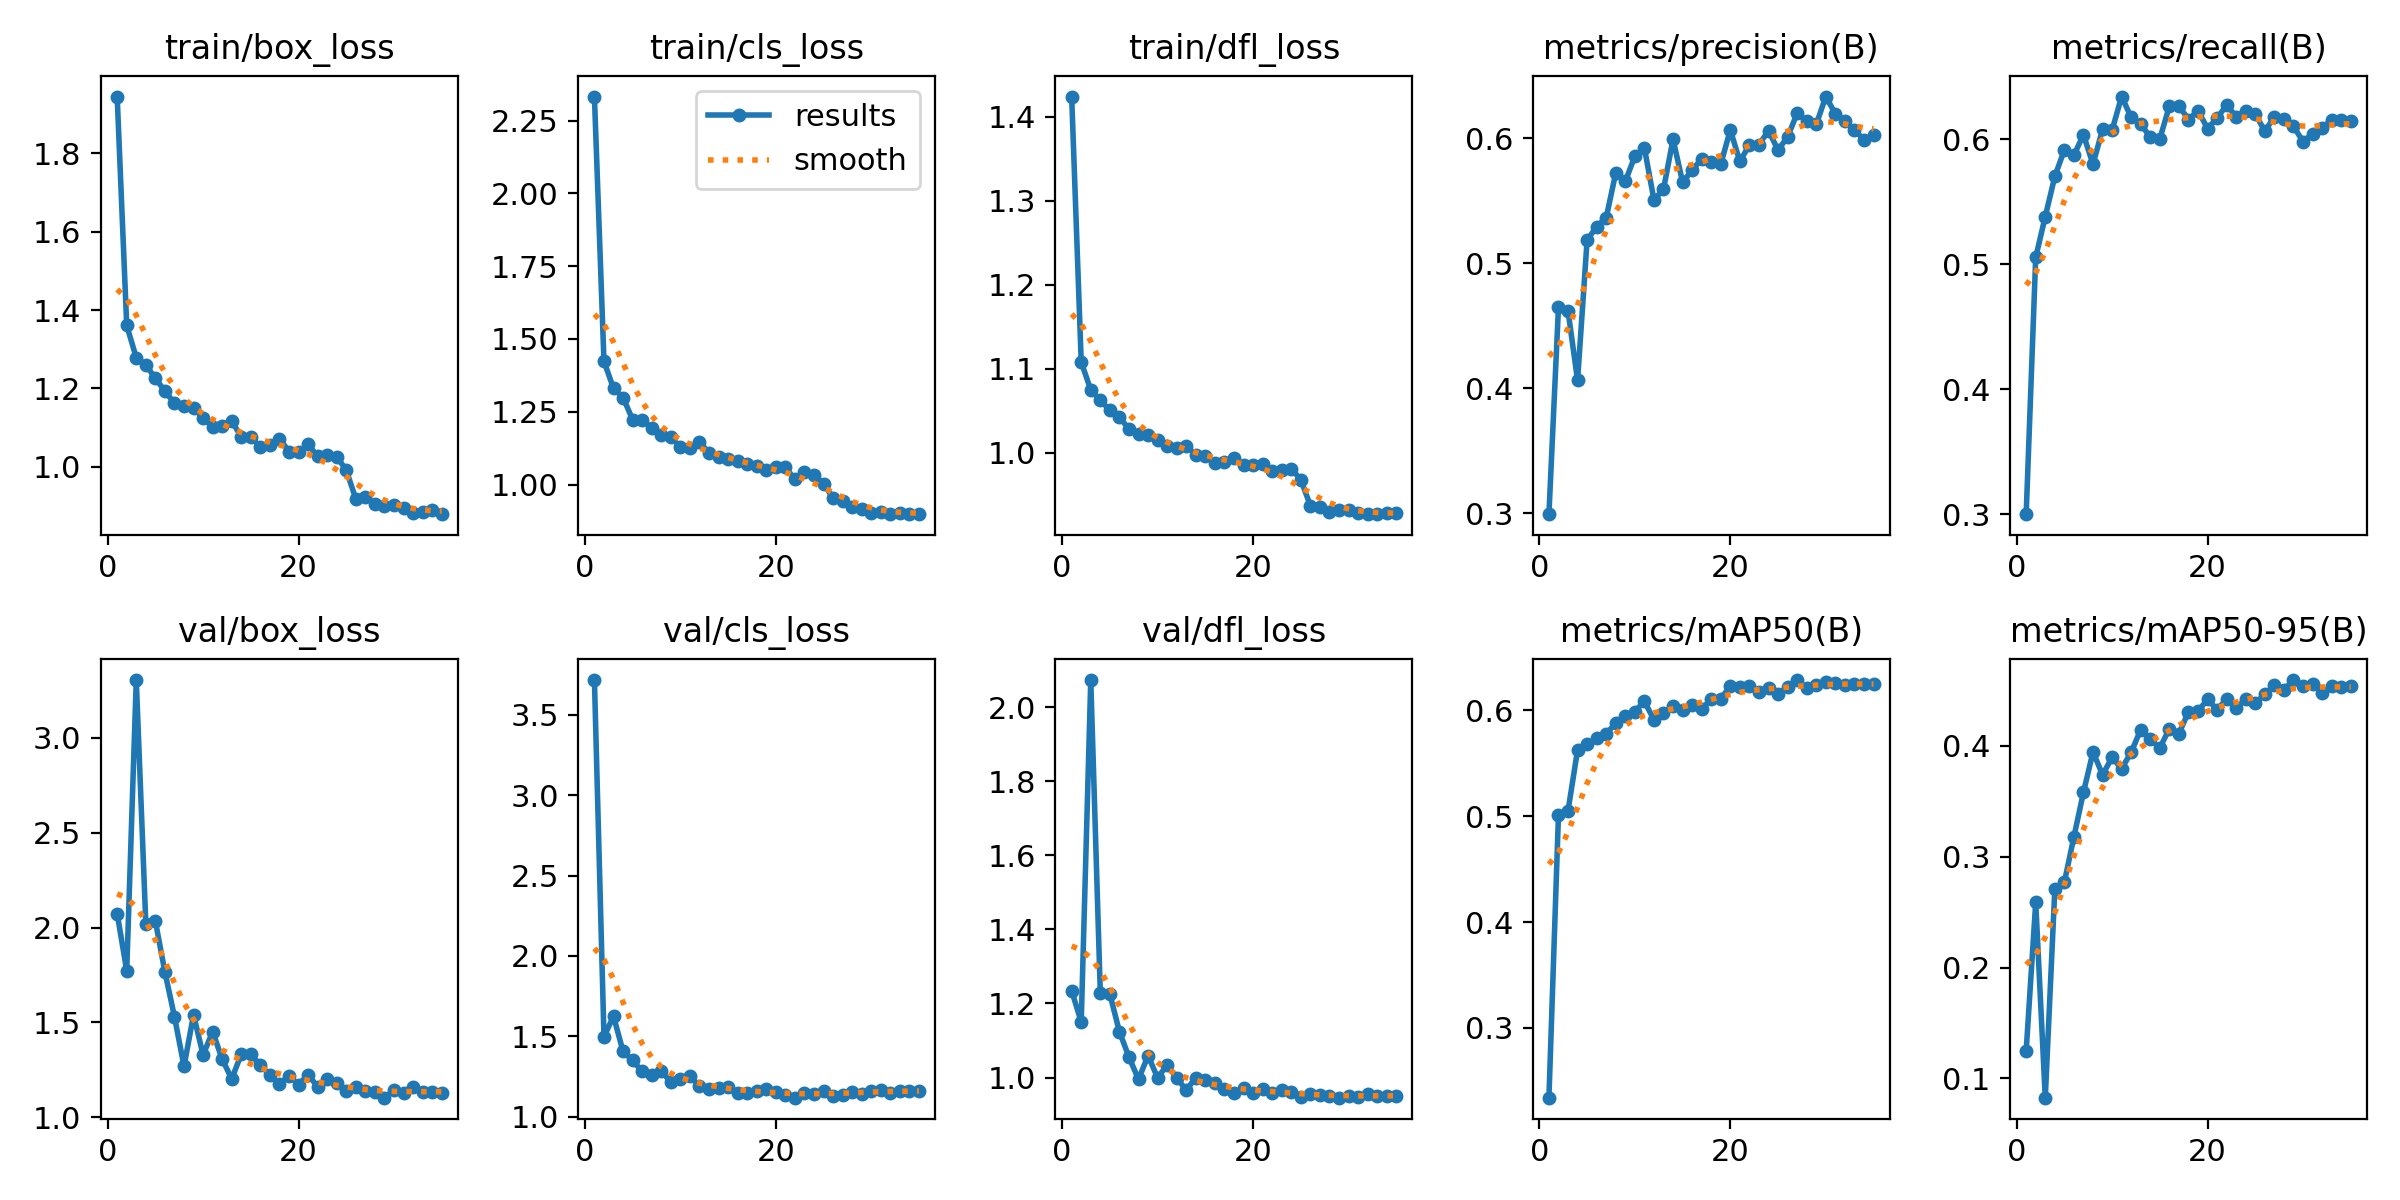

In [13]:
IPyImage(filename=f'../../runs/detect/{EXP_NAME}4/results.png', width=800)